<a href="https://colab.research.google.com/github/FLOWER-2024/TPTITANIC/blob/main/Groupe3_ouarem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Importation des bibliothèques

In [11]:
# Step 1: Setup and Data Loading
# ---------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer # Using a more advanced imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#2.Chargement et préparation initiale des données

In [12]:
# Data loading remains the same
data_path = '/content/myocardial+infarction+complications.zip'
col_names = [f'col_{i}' for i in range(1, 125)]
df = pd.read_csv(data_path, header=None, names=col_names, na_values='?', compression='zip', dtype=str)

print("Dataset loaded successfully.")

Dataset loaded successfully.


In [13]:
# Step 2: Data Cleaning and Preprocessing
# ----------------------------------------
complication_cols = [f'col_{i}' for i in range(113, 125)]
for col in complication_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['COMPLICATION'] = df[complication_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

feature_cols = [f'col_{i}' for i in range(2, 93)]
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

X = df[feature_cols]
y = df['COMPLICATION']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData split into training and validation sets.")

print("\nShape of the feature data (X):", X.shape)
print("Shape of the target data (y):", y.shape)
print("\nDistribution of the target variable (y):")
display(y.value_counts())

print("\nShape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)


Data split into training and validation sets.

Shape of the feature data (X): (1700, 91)
Shape of the target data (y): (1700,)

Distribution of the target variable (y):


,count
COMPLICATION,
1,1037
0,663



Shape of X_train: (1360, 91)
Shape of X_val: (340, 91)
Shape of y_train: (1360,)
Shape of y_val: (340,)


#3.Construction et optimisation de modèles d'ensemble

In [14]:
# On définit 3 pipelines, un pour chaque modèle de base.
# On utilise un imputer plus avancé : KNNImputer.

# Pipeline for Logistic Regression
pipe_lr = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Pipeline for RandomForest
pipe_rf = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline for XGBoost
pipe_xgb = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [15]:
# On crée l'ensemble model (VotingClassifier)
# voting='soft' est souvent meilleur car il moyenne les probabilités
ensemble_clf = VotingClassifier(
    estimators=[('lr', pipe_lr), ('rf', pipe_rf), ('xgb', pipe_xgb)],
    voting='soft'
)

In [16]:
# Grille de paramètres pour chaque modèle dans l'ensemble
# Les noms sont préfixés par 'nomdumodele__' (ex: 'xgb__classifier__max_depth')
param_dist = {
    'rf__classifier__n_estimators': [100, 200],
    'rf__classifier__max_depth': [5, 10, None],
    'xgb__classifier__n_estimators': [100, 200],
    'xgb__classifier__max_depth': [3, 5, 7],
    'xgb__classifier__learning_rate': [0.05, 0.1],
    'lr__classifier__C': [0.1, 1.0, 10.0]
}

In [17]:

# On lance la recherche d'hyperparamètres sur l'ensemble du modèle
random_search = RandomizedSearchCV(
    estimator=ensemble_clf,
    param_distributions=param_dist,
    n_iter=20, # On teste moins de combinaisons car l'entraînement est plus long
    cv=3,      # On réduit la validation croisée pour aller plus vite
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\nStarting hyperparameter tuning for the Ensemble model...")
random_search.fit(X_train, y_train)

print("\nEnsemble model tuning complete.")
print(f"Best F1 Score found: {random_search.best_score_:.4f}")
print("Best parameters found:")
print(random_search.best_params_)

best_ensemble = random_search.best_estimator_


Starting hyperparameter tuning for the Ensemble model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:30:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble model tuning complete.
Best F1 Score found: 0.7478
Best parameters found:
{'xgb__classifier__n_estimators': 200, 'xgb__classifier__max_depth': 3, 'xgb__classifier__learning_rate': 0.1, 'rf__classifier__n_estimators': 200, 'rf__classifier__max_depth': None, 'lr__classifier__C': 1.0}


#4.Evaluation de modele final



Evaluating the best ensemble model on the validation set...

F1 Score on Validation Set: 0.7833

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       133
           1       0.80      0.77      0.78       207

    accuracy                           0.74       340
   macro avg       0.73      0.73      0.73       340
weighted avg       0.74      0.74      0.74       340


Confusion Matrix:


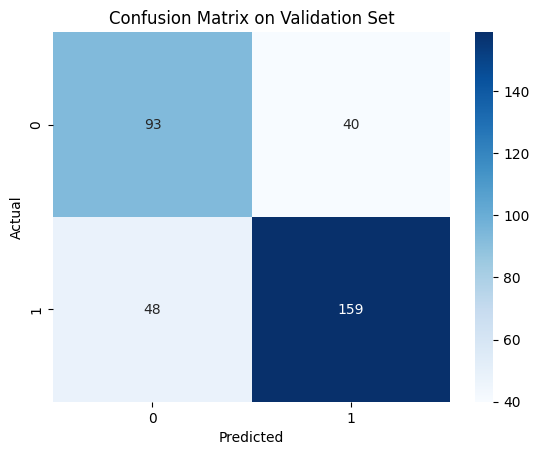

In [18]:
# Step 4: Final Model Evaluation
print("\nEvaluating the best ensemble model on the validation set...")
y_pred_val = best_ensemble.predict(X_val)

f1 = f1_score(y_val, y_pred_val)
print(f"\nF1 Score on Validation Set: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

#5.Génération du fichier de prédiction final

In [19]:
# Step 5: Generating the Final Prediction File
# ---------------------------------------------
def predict_and_save(model, test_data, output_filename):
    if 'ID' not in test_data.columns:
        test_data['ID'] = range(len(test_data))

    test_features = test_data[feature_cols].copy()
    for col in test_features.columns:
        test_features[col] = pd.to_numeric(test_features[col], errors='coerce')
    predictions = model.predict(test_features)
    submission_df = pd.DataFrame({'ID': test_data['ID'], 'pred': predictions})
    submission_df.to_csv(output_filename, index=False)
    print(f"\nPrediction file '{output_filename}' created successfully.")
    print("Head of the submission file:")
    print(submission_df.head())

X_val_with_id = X_val.copy()
X_val_with_id['ID'] = X_val.index
predict_and_save(
    model=best_ensemble,
    test_data=X_val_with_id,
    output_filename='Groupe_Ensemble_Submission.csv'
)


Prediction file 'Groupe_Ensemble_Submission.csv' created successfully.
Head of the submission file:
        ID  pred
1459  1459     1
518    518     0
1693  1693     1
1680  1680     1
611    611     1


#6.Prédictions sur dfTest.csv

In [22]:
# Étape finale: Prédictions sur dfTest.csv
test_data_path = '/content/dfTest.csv'
test_df = pd.read_csv(test_data_path)

# Assurez-vous que les colonnes correspondent (V2 à V92 pour les 91 features)
# Si les noms diffèrent, on peut renommer ou sélectionner par indices
test_df.columns = ['ID'] + [f'col_{i}' for i in range(1, 112)]  # Renommage pour correspondre à feature_cols

predict_and_save(
    model=best_ensemble,
    test_data=test_df,
    output_filename='predictions_dfTest.csv'
)


Prediction file 'predictions_dfTest.csv' created successfully.
Head of the submission file:
     ID  pred
0   297     1
1  1074     1
2    63     1
3   301     1
4   739     1
